Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 4.0MB/s 


In [0]:
import numpy as np

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [76]:
#Do train/validate/test split with the Tanzania Waterpumps data.
train, val = train_test_split(train, random_state=42)

train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [77]:
#for extra measure, a mini test set as well

val, my_test = train_test_split(val, random_state=42)

train.shape, val.shape, my_test.shape, test.shape

((44550, 41), (11137, 41), (3713, 41), (14358, 40))

In [10]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
24947,33935,20.0,2011-03-08,Government Of Tanzania,330,Ce,38.123839,-6.087137e+00,Ccm,0,Wami / Ruvu,Kilangawageni,Pwani,6,1,Bagamoyo,Mbwewe,80,True,GeoData Consultants Ltd,VWC,Kwaruhombo wa,True,1972,ksb,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
22630,49654,0.0,2013-02-16,Dwsp,0,DWE,0.000000,-2.000000e-08,Mwamahonza,0,Lake Victoria,Mwamahala,Mwanza,17,1,Magu,Nkungulu,0,NaN,GeoData Consultants Ltd,WUG,NaN,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
13789,39287,0.0,2011-08-13,Dasip,0,DASIP,33.312321,-2.814100e+00,Chanongu,0,Lake Victoria,Chanongu,Mwanza,19,4,Kwimba,Wala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
15697,60510,0.0,2013-01-20,Government Of Tanzania,1542,GOVERNMENT,34.783049,-4.842093e+00,Zahanati,0,Internal,Mungumaji,Singida,13,4,Singida Urban,Mungumaji,23,True,GeoData Consultants Ltd,WUA,NaN,True,2010,gravity,gravity,gravity,wua,user-group,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
22613,24259,0.0,2013-09-03,World Bank,523,Government,34.660944,-1.070733e+01,Kwa Mzee Charles,0,Lake Nyasa,Tumba,Ruvuma,10,3,Mbinga,Mbaha,1,NaN,GeoData Consultants Ltd,VWC,Government,True,2013,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional


In [9]:
train.describe()
#unclear whether amount_tsh should contain zeroes, but it has a lot of them,
#so I'll leave it be
#num_private wasn't in the data dictionary
#0 is probably a valid code for gps_height (which ranges from negative to positive)
#so even if some/all of the zeroes are wrong, it doesn't seem right to replace them

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,44550.000000,4.455000e+04,44550.000000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37087.547744,326.361114,668.105926,34.098625,-5.707581e+00,0.515376,15.366846,5.651291,178.793333,1303.746083
std,21436.367755,3291.640548,693.033591,6.530153,2.941883e+00,13.633690,17.696176,9.690341,471.050949,950.647840
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18555.250000,0.000000,0.000000,33.087274,-8.529283e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,36992.500000,0.000000,369.000000,34.914362,-5.022018e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55631.500000,20.000000,1320.000000,37.181498,-3.327652e+00,0.000000,17.000000,5.000000,211.750000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [79]:
#Define a function to wrangle train, validate, and test sets in the same way. 
#Clean outliers and engineer features.

def wrangle(X):
  """Wrangle train, validate, and test sets in the same way"""
    
  # Prevent SettingWithCopyWarning
  X = X.copy()
    
  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  cols_with_zeros = ['longitude', 'latitude','construction_year','population']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
  
  #drop duplicate columns
  # quantity & quantity_group are duplicates, so drop one
  # payment == payment_type
  X = X.drop(columns=['quantity_group','payment_type'])
  
  #recode permit to 1/0
  #this doesn't turn out make a meaningful difference
  #X['permit'] = X['permit'].replace({True: 1, False: 0})
  
  #new feature: whether amount_tsh is 0 or not
  #it turns out to be wildly unimportant!
  #X['0_tsh'] = X['amount_tsh'] == 0
  
  #convert date_recorded to datetime
  X['date_recorded'] = X['date_recorded'].apply(pd.to_datetime)
  
  #create 'age' column, the number of years between construction and evaluation
  X['age'] = X['date_recorded'].apply(lambda d: d.year) - X['construction_year']
  
  #pare down high-cardinality variables prior to one-hot
  #if a category has fewer than threshold observations, nan it
  threshold = 600 #tweaking threshold value for best results
  value_counts = X['funder'].value_counts()
  to_remove = value_counts[value_counts < threshold].index
  X['funder'] = X['funder'].replace(to_remove, np.nan)
  
  value_counts = X['installer'].value_counts()
  to_remove = value_counts[value_counts < threshold].index
  X['installer'] = X['installer'].replace(to_remove, np.nan)
  
  value_counts = X['lga'].value_counts()
  to_remove = value_counts[value_counts < threshold].index
  X['lga'] = X['lga'].replace(to_remove, np.nan)
  
  #scheme_management has fine cardinality but a pesky "None" observed once
  X['scheme_management'] = X['scheme_management'].replace('None', np.nan)
    
  # return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
my_test = wrangle(my_test)
test = wrangle(test)

train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,0_tsh,age
24947,33935,20.0,2011-03-08,Government Of Tanzania,330,NaN,38.123839,-6.087137,Ccm,0,Wami / Ruvu,Kilangawageni,Pwani,6,1,Bagamoyo,Mbwewe,80.0,True,GeoData Consultants Ltd,VWC,Kwaruhombo wa,True,1972.0,ksb,submersible,submersible,vwc,user-group,pay per bucket,salty,salty,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional,False,39.0
22630,49654,0.0,2013-02-16,Dwsp,0,DWE,NaN,NaN,Mwamahonza,0,Lake Victoria,Mwamahala,Mwanza,17,1,Magu,Nkungulu,NaN,NaN,GeoData Consultants Ltd,WUG,NaN,False,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,True,NaN
13789,39287,0.0,2011-08-13,NaN,0,NaN,33.312321,-2.814100,Chanongu,0,Lake Victoria,Chanongu,Mwanza,19,4,NaN,Wala,NaN,True,GeoData Consultants Ltd,VWC,NaN,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,True,NaN
15697,60510,0.0,2013-01-20,Government Of Tanzania,1542,NaN,34.783049,-4.842093,Zahanati,0,Internal,Mungumaji,Singida,13,4,NaN,Mungumaji,23.0,True,GeoData Consultants Ltd,WUA,NaN,True,2010.0,gravity,gravity,gravity,wua,user-group,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,True,3.0
22613,24259,0.0,2013-09-03,World Bank,523,Government,34.660944,-10.707331,Kwa Mzee Charles,0,Lake Nyasa,Tumba,Ruvuma,10,3,NaN,Mbaha,1.0,NaN,GeoData Consultants Ltd,VWC,Government,True,2013.0,gravity,gravity,gravity,vwc,user-group,unknown,soft,good,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional,True,0.0


In [0]:
#Select features. Use a scikit-learn pipeline to encode categoricals, 
#impute missing values, and fit a decision tree classifier.

target = 'status_group'
features = ['amount_tsh','funder','gps_height','installer','longitude','latitude',
            'basin','region','lga','population','permit','construction_year',
           'extraction_type_group','management','payment','water_quality',
           'quantity','source','waterpoint_type','age','0_tsh']
#this feature list is a little arbitrary in the distinctions between type/group etc
#I'm tweaking it iteratively 

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_my_test = my_test[features]
y_my_test = my_test[target]

X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [81]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), #encodes categoricals
    SimpleImputer(strategy='mean'), #imputes missing values with the means
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42) #makes a decision tree
)

#fit tree
pipeline.fit(X_train, y_train)

#Get your validation accuracy score.

#check accuracy of tree model
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
#definitely overfit to training data, but that's pretty good validation!

Train Accuracy 0.8065544332210999
Validation Accuracy 0.7480470503726317


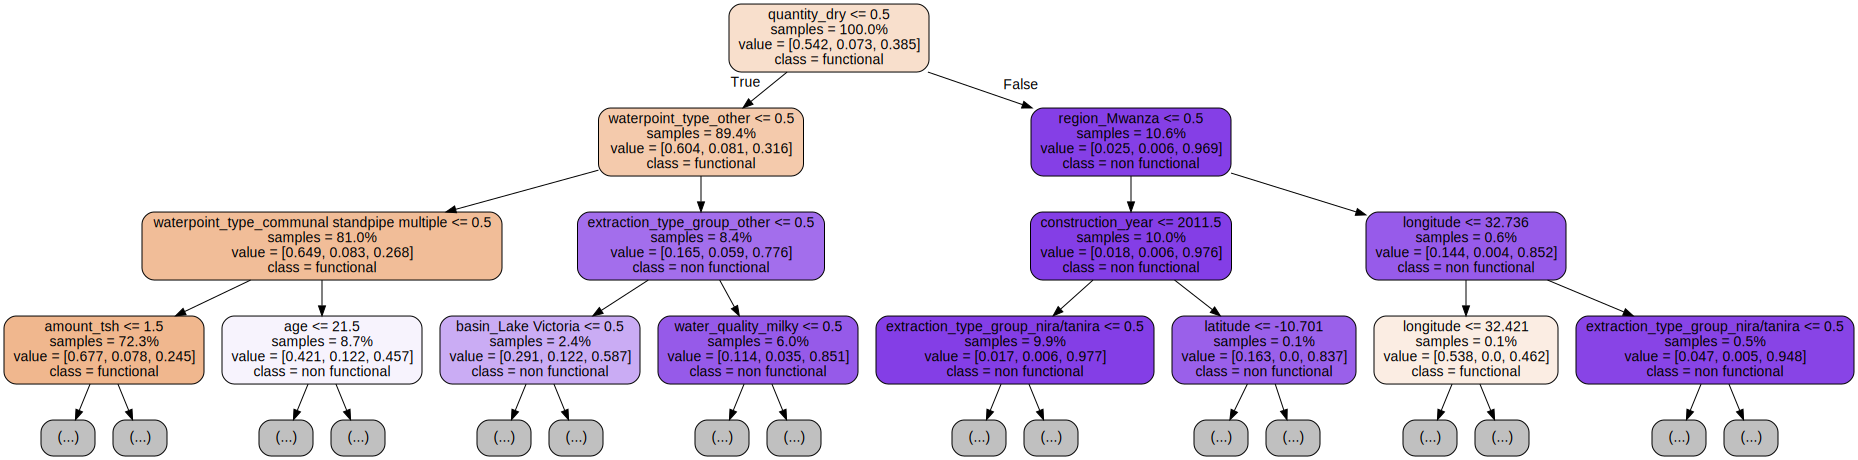

In [38]:
#let's look at the tree!
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [0]:
import matplotlib.pyplot as plt

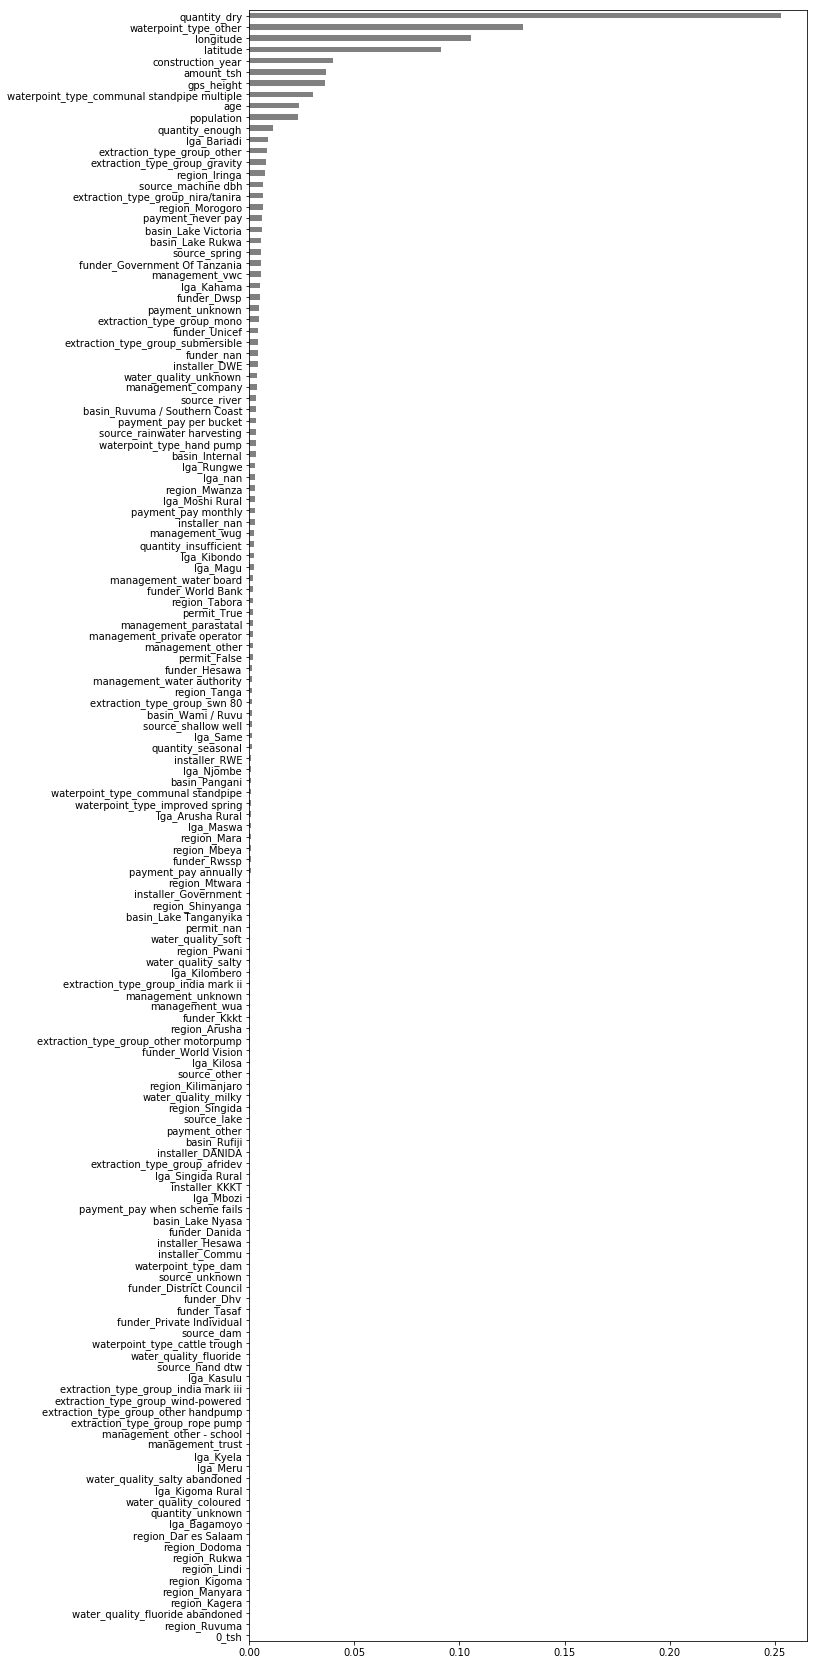

In [82]:
#Get and plot your feature importances.

model = pipeline.named_steps['decisiontreeclassifier']

encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [83]:
print('Test Accuracy', pipeline.score(X_my_test, y_my_test))

Test Accuracy 0.7581470509022354


In [85]:
y_pred = pipeline.predict(X_test)

y_pred

array(['non functional', 'non functional', 'functional', ...,
       'functional', 'functional', 'non functional'], dtype=object)

In [89]:
submission = pd.DataFrame(data={'id':test['id'],'status_group':y_pred})

submission.head()

,id,status_group
0,50785,non functional
1,51630,non functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission.to_csv('second_submission.csv', index=False)